In [1]:
## import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
!pip install wget
import wget

import sys, os, re, gc
from random import sample
import numpy.linalg as LA

from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import KernelPCA
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=15651da1ec332368d14cf162b7e8b3d38181679a1cd14bac4c15c611450a8592
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
acp_feature_extraction = wget.download('https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/utils/acp_feature_extraction.py')
ACP_DL_path = wget.download('https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/trained_models/ACP_DL.h5')
ACP_MHCNN_path = wget.download('https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/trained_models/ACP_MHCNN.h5')
ACP_LSE_path = wget.download('https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/trained_models/ACP-LSE/ACP-LSE2.h5')
from acp_feature_extraction import *

In [3]:
random_sequences = 'https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/Data/random_from_func.txt'
trained_sequences = 'https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/Data/gen_from_model.txt'
acp740 = 'https://raw.githubusercontent.com/mhdshl/ACP_Seq2Seq/main/Data/acp740.txt'

## Prediction using Deep learning-based ACP Classifiers
### ACP-DL, ACP-MHCNN, and ACP-LSE

In [4]:
ACP_DL = tf.keras.models.load_model(ACP_DL_path)
ACP_MHCNN = tf.keras.models.load_model(ACP_MHCNN_path)
ACP_LSE = tf.keras.models.load_model(ACP_LSE_path)

### ACP-MHCNN

In [5]:
BPF_rand = numeric(dBPF, random_sequences)
dBIT_rand = numeric(dBIT, random_sequences)
dBLOSUM_rand = numeric(dBLOSUM, random_sequences)
BPF_rand = BPF_rand[:4000]
dBIT_rand = dBIT_rand[:4000]
dBLOSUM_rand = dBLOSUM_rand[:4000]

print(BPF_rand.shape)
print(dBIT_rand.shape)
print(dBLOSUM_rand.shape)

BPF_trained = numeric(dBPF, trained_sequences)
dBIT_trained = numeric(dBIT, trained_sequences)
dBLOSUM_trained = numeric(dBLOSUM, trained_sequences)
BPF_trained = BPF_trained[:4000]
dBIT_trained = dBIT_trained[:4000]
dBLOSUM_trained = dBLOSUM_trained[:4000]

print(BPF_trained.shape)
print(dBIT_trained.shape)
print(dBLOSUM_trained.shape)

172082/172082 [==============================] - 0s 0us/step
(4000, 25, 20)
(4000, 25, 31)
(4000, 25, 20)
207503/207503 [==============================] - 0s 0us/step
(4000, 25, 20)
(4000, 25, 31)
(4000, 25, 20)


In [6]:
y_pred_rand_MHCNN = ACP_MHCNN.predict([BPF_rand, dBIT_rand, dBLOSUM_rand])
y_pred_trained_MHCNN = ACP_MHCNN.predict([BPF_trained, dBIT_trained, dBLOSUM_trained])
print(y_pred_rand_MHCNN.shape)
print(y_pred_trained_MHCNN.shape)
pred_label_rand = np.argmax(y_pred_rand_MHCNN, axis=1)
pred_label_trained = np.argmax(y_pred_trained_MHCNN, axis=1)
print(pred_label_rand.shape)
print(pred_label_trained.shape)

125/125 [==============================] - 0s 4ms/step
(4000, 2)
(4000, 2)
(4000,)
(4000,)


### ACP-DL

In [7]:
bpf_rand, kmer_rand, label_rand = prepare_feature_ACP_DL(random_sequences)
bpf_rand = bpf_rand[:4000]
kmer_rand = kmer_rand[:4000]
label_rand = label_rand[:4000]
print(bpf_rand.shape)
print(kmer_rand.shape)
print(len(label_rand))

bpf_trained, kmer_trained, label_trained = prepare_feature_ACP_DL(trained_sequences)
bpf_trained = bpf_trained[:4000]
kmer_trained = kmer_trained[:4000]
label_trained = label_trained[:4000]
print(bpf_trained.shape)
print(kmer_trained.shape)
print(len(label_trained))

(4000, 140)
(4000, 343)
4000
(4000, 140)
(4000, 343)
4000


In [8]:
data_dim = 483
timesteps = 1
x_rand = np.concatenate((bpf_rand, kmer_rand), axis=1)
x_rand = np.reshape(x_rand, (len(x_rand), timesteps, data_dim))
x_trained = np.concatenate((bpf_trained, kmer_trained), axis=1)
x_trained = np.reshape(x_trained, (len(x_trained), timesteps, data_dim))
print(x_rand.shape)
print(x_trained.shape)

(4000, 1, 483)
(4000, 1, 483)


In [9]:
y_rand_pred_DL = ACP_DL.predict(x_rand)
y_trained_pred_DL = ACP_DL.predict(x_trained)
print(y_rand_pred_DL.shape)
print(y_trained_pred_DL.shape)

125/125 [==============================] - 1s 4ms/step
(4000, 1)
(4000, 1)


In [10]:
from keras.utils import to_categorical

y_rand_label_DL = np.round(y_rand_pred_DL)
y_trained_label_DL = np.round(y_trained_pred_DL)
y_rand_label_DL = to_categorical(y_rand_label_DL)
y_trained_label_DL = to_categorical(y_trained_label_DL)
y_rand_label_DL = np.argmax(y_rand_label_DL, axis=1)
y_trained_label_DL = np.argmax(y_trained_label_DL, axis=1)
y_rand_label_DL = y_rand_label_DL.astype(int)
y_trained_label_DL = y_trained_label_DL.astype(int)
print(y_rand_label_DL.shape)
print(y_trained_label_DL.shape)

(4000,)
(4000,)


### ACP-LSE

In [11]:
[DataX_rand, LabelY_rand] = Convert_Seq2CKSAAP(prepare_feature_for_CKSAAP(random_sequences), gap=8)
DataX_rand = DataX_rand[:4000]
LabelY_rand = LabelY_rand[:4000]
print(DataX_rand.shape)
print(LabelY_rand.shape)
[DataX_trained, LabelY_trained] = Convert_Seq2CKSAAP(prepare_feature_for_CKSAAP(trained_sequences), gap=8)
DataX_trained = DataX_trained[:4000]
LabelY_trained = LabelY_trained[:4000]
print(DataX_trained.shape)
print(LabelY_trained.shape)

num pos: 4065 num neg: 0
(4000, 3600)
(4000, 1)
num pos: 5266 num neg: 0
(4000, 3600)
(4000, 1)


In [12]:
y_pred_rand_LSE, _ = ACP_LSE.predict(DataX_rand)
y_pred_trained_LSE, _ = ACP_LSE.predict(DataX_trained)
print(y_pred_rand_LSE.shape)
print(y_pred_trained_LSE.shape)

125/125 [==============================] - 0s 4ms/step
(4000, 2)
(4000, 2)


In [13]:
y_pred_label_rand_LSE = np.argmax(y_pred_rand_LSE, axis=1)
y_pred_label_trained_LSE = np.argmax(y_pred_trained_LSE, axis=1)
print(y_pred_label_rand_LSE.shape)
print(y_pred_label_trained_LSE.shape)

(4000,)
(4000,)


## Analysis

### 1st Tier Filtering

In [24]:
ACP_sequences = prepare_feature_for_CKSAAP(trained_sequences)
ACP_sequences = ACP_sequences[0:4000]
ACP_synthetic_sequences = []
for i in range(0, len(ACP_sequences)):
  ACP_synthetic_sequences.append(ACP_sequences[i][1])
ACP_synthetic_sequences = np.array(ACP_synthetic_sequences)
print(ACP_synthetic_sequences)

['GLIGKVGPNVSGLLKKL' 'AVSKALRKSFAKLAVTIVRHG' 'GFGCPFAQVPIKKVAQGLKSVGKKLL'
 ... 'GFNCPNRDPGVCKSL'
 'KWAGAAAAAPPVNTKPGPYSLKPAPSVGVCGENCKGGFTCGTGSCKKRSGRPTCVCYRCANGGGDIPLGALGGVGKKLDGTKS'
 'GIIKKVIKKIIKKI']


In [22]:
matching_seq_ind_trained = []
for i in range(0, LabelY_trained.shape[0]):
  if y_trained_label_DL[i] == pred_label_trained[i] == y_pred_label_trained_LSE[i] == 1:
    matching_seq_ind_trained.append(i)
print('Number of Positive ACPs (rank = 3) for ACPs generated using our model:',len(matching_seq_ind_trained))
print('Total number of sequences (trained):',LabelY_trained.shape[0])
print('Accuracy = ', len(matching_seq_ind_trained)/LabelY_trained.shape[0])

Number of Positive ACPs (rank = 3) for ACPs generated using our model: 1477
Total number of sequences (trained): 4000
Accuracy =  0.36925


In [26]:
first_tier_sequences = ACP_synthetic_sequences[matching_seq_ind_trained]
print(first_tier_sequences.shape)
dataset = pd.DataFrame({'First Tier Filtered Sequences': list(first_tier_sequences), 'First Tier Filtered Sequences': list(first_tier_sequences)}, columns=['First Tier Filtered Sequences'])
dataset.to_excel("First_tier_sequences.xlsx")

(1477,)


In [28]:
matching_seq_ind_rand = []
for i in range(0, LabelY_rand.shape[0]):
  if y_rand_label_DL[i] == pred_label_rand[i] == y_pred_label_rand_LSE[i] == 1:
    matching_seq_ind_rand.append(i)
print('Number of Positive ACPs (rank = 3) for randomly generated ACPs:',len(matching_seq_ind_rand))
print('Total number of sequences (random):',LabelY_rand.shape[0])
print('Accuracy = ', len(matching_seq_ind_rand)/LabelY_rand.shape[0])

Number of Positive ACPs (rank = 3) for randomly generated ACPs: 455
Total number of sequences (random): 4000
Accuracy =  0.11375


In [36]:
bpf_trained_filtered = bpf_trained[matching_seq_ind_trained]
kmer_trained_filtered = kmer_trained[matching_seq_ind_trained]
print(bpf_trained_filtered.shape)
print(kmer_trained_filtered.shape)

label_trained_filtered = y_trained_label_DL[matching_seq_ind_trained]
print(label_trained_filtered.shape)

x_filtered_trained = np.concatenate((bpf_trained_filtered, kmer_trained_filtered), axis=1)
x_filtered_trained = np.reshape(x_filtered_trained, (len(x_filtered_trained), timesteps, data_dim))
print(x_filtered_trained.shape)

(1477, 140)
(1477, 343)
(1477,)
(1477, 1, 483)


## tSNE

In [42]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import numpy as np

In [35]:
model_tsne = tensorflow.keras.Model(ACP_DL.inputs, ACP_DL.layers[-2].input)
model_tsne.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1_input (InputLayer)    [(None, 1, 483)]          0         
                                                                 
 lstm1 (LSTM)                (None, 128)               313344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
Total params: 313344 (1.20 MB)
Trainable params: 313344 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
bpf_740, kmer_740, label_740 = prepare_feature_ACP_DL(acp740)
print(bpf_740.shape)
print(kmer_740.shape)
print(len(label_740))
features_DL = np.concatenate((bpf_740, kmer_740), axis=1)
features_DL = np.reshape(features_DL, (len(features_DL), timesteps, data_dim))
print(features_DL.shape)

(740, 140)
(740, 343)
740
(740, 1, 483)


In [38]:
features_DL = model_tsne.predict(features_DL)
print(features_DL.shape)

DL_filtered_features = model_tsne.predict(x_filtered_trained)
print(DL_filtered_features.shape)

24/24 [==============================] - 1s 3ms/step
(740, 128)
47/47 [==============================] - 0s 3ms/step
(1477, 128)


In [53]:
combined_seq = np.concatenate((features_DL, DL_filtered_features), axis=0)
print(combined_seq.shape)
normalizer = Normalizer().fit(combined_seq)
combined_norm = normalizer.transform(combined_seq)

# transformer = KernelPCA(n_components=2)
# transformer.fit_transform(combined_norm)
# combined_CKSAAP_tsne = transformer.transform(combined_norm)

tsne = TSNE(n_components=2, random_state=123)
combined_CKSAAP_tsne = tsne.fit_transform(combined_norm)

print(combined_CKSAAP_tsne.shape)

(2217, 128)
(2217, 2)


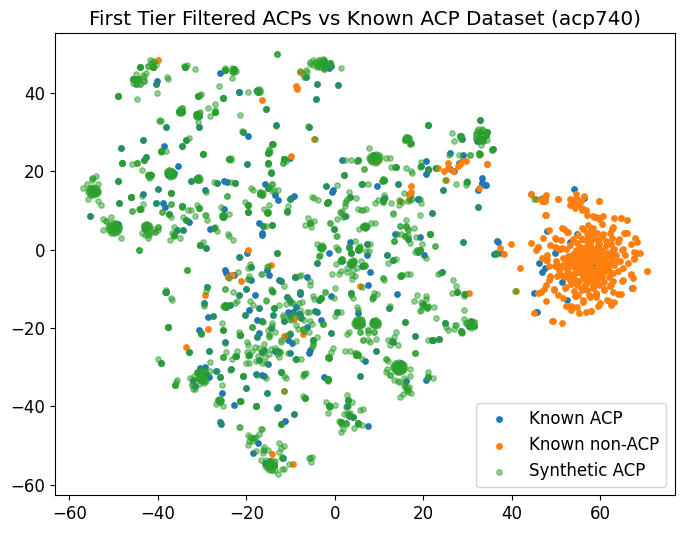

In [55]:
import matplotlib.pyplot as plt

marker_size = 15
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize =(8, 6))
plt.scatter(combined_CKSAAP_tsne[0:376,0],combined_CKSAAP_tsne[0:376,1],s=marker_size,label='Known ACP')
plt.scatter(combined_CKSAAP_tsne[376:740,0],combined_CKSAAP_tsne[376:740,1],s=marker_size,label='Known non-ACP')
plt.scatter(combined_CKSAAP_tsne[740:-1,0],combined_CKSAAP_tsne[740:-1,1],s=marker_size,alpha = 0.5, label='Synthetic ACP')
plt.legend() # loc='upper right'
plt.title('First Tier Filtered ACPs vs Known ACP Dataset (acp740)')
plt.savefig('first_tier_vs_740.png',dpi=(300), bbox_inches='tight')
# plt.savefig('first_tier_vs_740.eps', format='eps')
plt.savefig('first_tier_vs_740.pdf', format='pdf', bbox_inches='tight')